In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [37]:
# Change if we want to use all songs instead of just pop
df = pd.read_csv("pop_genres_dataset.csv")

# Make these permanent changes to the dataset??
# Miliseconds to seconds
df["duration_ms"] = df["duration_ms"] / 1000
df = df.rename(columns={"duration_ms": "duration_s"})

df = pd.get_dummies(df, columns=["track_genre"])

df.head()

,artists,track_name,popularity,duration_s,explicit,danceability,energy,key,loudness,mode,...,time_signature,track_genre_cantopop,track_genre_indie-pop,track_genre_j-pop,track_genre_k-pop,track_genre_mandopop,track_genre_pop,track_genre_pop-film,track_genre_power-pop,track_genre_synth-pop
0,my little airport,每次你走的時分,47,183.968,0,0.576,0.505,11,-13.070,0,...,4,True,False,False,False,False,False,False,False,False
1,my little airport,下了兩天雨,44,172.343,0,0.577,0.228,11,-14.684,1,...,4,True,False,False,False,False,False,False,False,False
2,my little airport,詩歌舞街,50,191.308,0,0.641,0.479,4,-15.395,1,...,4,True,False,False,False,False,False,False,False,False
3,my little airport,那陣時不知道,48,148.564,0,0.613,0.210,5,-15.309,1,...,4,True,False,False,False,False,False,False,False,False
4,Eason Chan,無條件,54,228.973,0,0.646,0.370,0,-10.980,1,...,4,True,False,False,False,False,False,False,False,False


In [38]:
print(df.columns)

Index(['artists', 'track_name', 'popularity', 'duration_s', 'explicit',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'track_genre_cantopop', 'track_genre_indie-pop',
       'track_genre_j-pop', 'track_genre_k-pop', 'track_genre_mandopop',
       'track_genre_pop', 'track_genre_pop-film', 'track_genre_power-pop',
       'track_genre_synth-pop'],
      dtype='object')


We chose to have danceability as a response variable as it's numeric and non-discrete. The predictors will be determined through feature selection.

In [ ]:
X = df.drop(["danceability", "artists", "track_name"], axis=1)
y = df["danceability"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature selection

In [50]:
# Feature selection
selector = SelectKBest(f_regression, k = 10) # Using 10 predictors
selector.fit(X_train, y_train)

mask = selector.get_support()
selected_cols = X_train.columns[mask]

X_train = X_train[selected_cols].copy()
X_test = X_test[selected_cols].copy()

print(X_train.columns)

Index(['popularity', 'explicit', 'speechiness', 'liveness', 'valence', 'tempo',
       'time_signature', 'track_genre_k-pop', 'track_genre_pop',
       'track_genre_power-pop'],
      dtype='object')


From the feature selection, we selected 10 variables to predict danceability: popularity, explicit, speechiness, liveness, valence, tempo, time signature, and one-hot encodings for whether or not the song is Kpop, pop, and power pop.

## Modelling

In [65]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

R²: 0.3417514076991939
RMSE: 0.11328760859165574
MAE: 0.08893907591258103


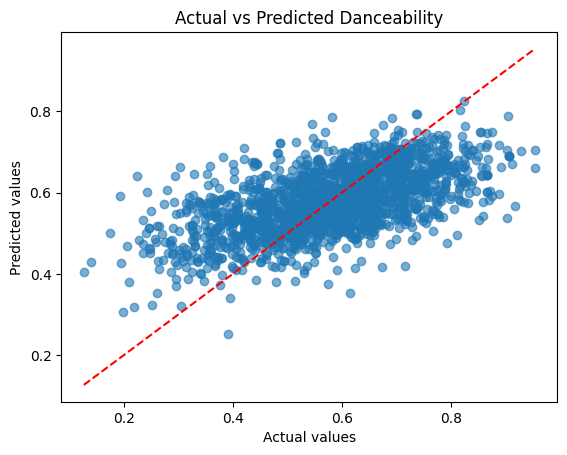

In [66]:
plt.scatter(y_test, y_pred, alpha = 0.6)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted Danceability")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

Based on the plot and low R^2 value, the model is underfitting to the data. This might be due to the fact that the true relationship between danceability and the predictors is non-linear, which the linear regression fails to capture.

## Regularization: Ridge regression

In [69]:
ridge = Ridge(alpha = 1)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

print("R²:", r2_score(y_test, ridge_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, ridge_pred)))
print("MAE:", mean_absolute_error(y_test, ridge_pred))

R²: 0.3416963038472791
RMSE: 0.11329235030553103
MAE: 0.08894405503764155


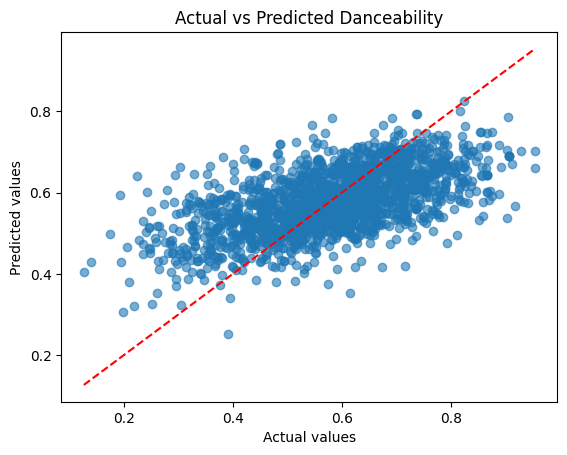

In [70]:
plt.scatter(y_test, ridge_pred, alpha = 0.6)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted Danceability")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

| Model             | R^2       | RMSE      | MAE       |
| --------------    | :-------: | :-------: | :-------: |
| Linear regression | 0.3418    | 0.1133    | 0.0889    |
| Ridge regression  | 0.3417    | 0.1133    | 0.0889    |

There's no sign of improvement with ridge regression - in fact, the R^2 value is slightly less than linear regression. This is due to the fact that regularization penalizes complexity to prevent overfitting. Since the initial model was already simple, adding the penalty further restricted the model from fitting the data.